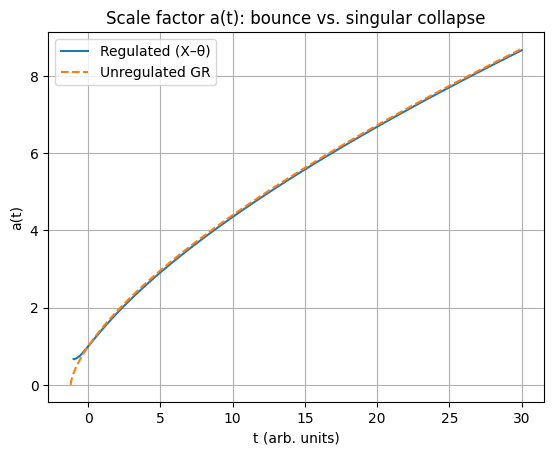

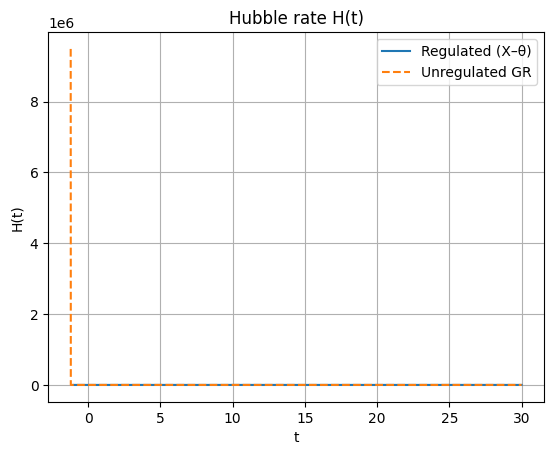

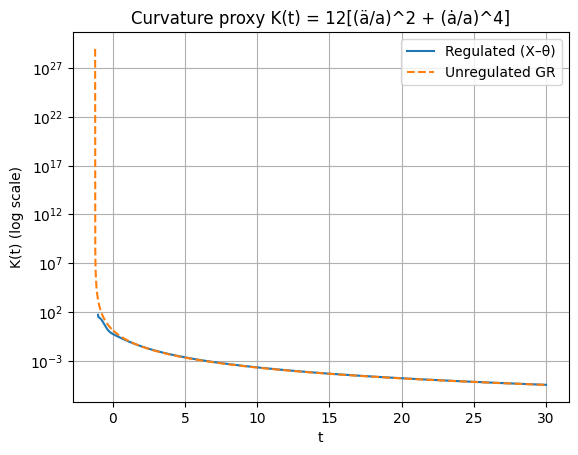

Regulated bounce: a_min ≈ 0.669567 at t ≈ -1.012
Unregulated GR reached a_min ≈ 1.000000e-06 (numerical floor)


In [1]:
# FRW bounce vs. GR-singularity: side-by-side simulations
# - Flat FRW with matter (w=0), radiation (w=1/3), and a θ-stiff component (w=1).
# - Regulated model: H^2 = (8πG/3) ρ (1 - ρ/ρ_c)
# - Unregulated GR:   H^2 = (8πG/3) ρ
#
# We integrate a(t) forward and backward in t and compute a proxy for curvature:
#   Kretschmann scalar for flat FRW: K = 12[ (ä/a)^2 + (ȧ/a)^4 ]
# computed numerically from a(t). Units are normalized so that 8πG/3 = 1.

import numpy as np
import matplotlib.pyplot as plt

Gbar = 1.0           # absorb 8πG/3 into units
rho_c = 1.0          # θ cutoff scale
rho_m0 = 0.3         # present-day densities at a=1
rho_r0 = 1e-4
rho_s0 = 1e-5        # θ-stiff (scales as a^{-6})

def rho_components(a):
    return (
        rho_m0 * a**(-3),   # matter
        rho_r0 * a**(-4),   # radiation
        rho_s0 * a**(-6),   # θ-stiff
    )

def rho_total(a):
    rm, rr, rs = rho_components(a)
    return rm + rr + rs

def H(a, regulated=True):
    r = rho_total(a)
    if regulated:
        return np.sqrt(np.maximum(Gbar * r * (1.0 - r/rho_c), 0.0))
    else:
        return np.sqrt(np.maximum(Gbar * r, 0.0))

def integrate(a0=1.0, tmax=20.0, dt=2e-3, regulated=True, a_floor=1e-6, a_cap=10.0):
    # forward
    tF, aF = [0.0], [a0]
    t, a = 0.0, a0
    nsteps = int(tmax/dt)
    for _ in range(nsteps):
        h = H(a, regulated=regulated)
        a = a + dt * a * h         # ȧ = a H
        t = t + dt
        if not np.isfinite(a): break
        aF.append(min(a, a_cap))
        tF.append(t)
        if a >= a_cap: break

    # backward
    tB, aB = [0.0], [a0]
    t, a = 0.0, a0
    for _ in range(nsteps):
        h = H(a, regulated=regulated)
        a = a - dt * a * h
        t = t - dt
        if not np.isfinite(a): break
        if a <= a_floor:
            aB.append(a_floor)
            tB.append(t)
            break
        aB.append(a)
        tB.append(t)
        if regulated and H(a, regulated=True) < 1e-8:
            # near the bounce: stop
            break

    # stitch
    t_all = np.array(list(reversed(tB)) + tF[1:])
    a_all = np.array(list(reversed(aB)) + aF[1:])
    return t_all, a_all

def numerical_Kretschmann(t, a):
    # finite differences with central scheme
    dt = np.gradient(t)
    adot = np.gradient(a, t, edge_order=2)
    addot = np.gradient(adot, t, edge_order=2)
    with np.errstate(divide='ignore', invalid='ignore'):
        H = adot / a
        term1 = (addot / a)**2
        term2 = (H**4)
        K = 12.0 * (term1 + term2)
    # clip any tiny negatives/NaNs due to numerical noise
    K = np.where(np.isfinite(K) & (K > 0), K, np.nan)
    return K, H

# Run both models
t_reg, a_reg = integrate(regulated=True, tmax=30.0, dt=2e-3)
t_gr,  a_gr  = integrate(regulated=False, tmax=30.0, dt=2e-3)

# Compute curvature proxies
K_reg, H_reg = numerical_Kretschmann(t_reg, a_reg)
K_gr,  H_gr  = numerical_Kretschmann(t_gr,  a_gr)

# Figure 1: a(t) comparison
plt.figure()
plt.plot(t_reg, a_reg, label="Regulated (X–θ)")
plt.plot(t_gr,  a_gr,  linestyle="--", label="Unregulated GR")
plt.title("Scale factor a(t): bounce vs. singular collapse")
plt.xlabel("t (arb. units)")
plt.ylabel("a(t)")
plt.legend()
plt.grid(True)
plt.show()

# Figure 2: H(t) comparison
plt.figure()
plt.plot(t_reg, H_reg, label="Regulated (X–θ)")
plt.plot(t_gr,  H_gr,  linestyle="--", label="Unregulated GR")
plt.title("Hubble rate H(t)")
plt.xlabel("t")
plt.ylabel("H(t)")
plt.legend()
plt.grid(True)
plt.show()

# Figure 3: Kretschmann scalar proxy K(t)
plt.figure()
plt.semilogy(t_reg, K_reg, label="Regulated (X–θ)")
plt.semilogy(t_gr,  K_gr,  linestyle="--", label="Unregulated GR")
plt.title("Curvature proxy K(t) = 12[(ä/a)^2 + (ȧ/a)^4]")
plt.xlabel("t")
plt.ylabel("K(t) (log scale)")
plt.legend()
plt.grid(True, which="both")
plt.show()

# Report key numbers
a_min_reg = np.nanmin(a_reg)
t_min_idx = np.nanargmin(a_reg)
t_min_reg = t_reg[t_min_idx]
print(f"Regulated bounce: a_min ≈ {a_min_reg:.6f} at t ≈ {t_min_reg:.3f}")
print(f"Unregulated GR reached a_min ≈ {np.nanmin(a_gr):.6e} (numerical floor)")
